In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn.metrics import mean_squared_error

warnings.filterwarnings(action='ignore') # Ignore warning message

# date path
data_path = '../data/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

Data Downcasting


In [2]:
print("shape of sales_train:", sales_train.shape)
print("shape of test:", test.shape)

shape of sales_train: (2935849, 6)
shape of test: (214200, 3)


In [3]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
        if df[col].dtype.name=="float64":
            df[col] = df[col].astype('float32')
            
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% compressed
38.5% compressed
54.2% compressed
39.8% compressed
70.8% compressed


### Feature Engineering I - handling sales_train, shops, items, item_categories

In [4]:
# Extract data with a item_price greater than 0
sales_train = sales_train[sales_train['item_price'] > 0]
# Extract data with a item_priceof less than 50,000
sales_train = sales_train[sales_train['item_price'] < 50000]
# Extract data with item_cnt_day greater than 0
sales_train = sales_train[sales_train['item_cnt_day'] > 0]
# Extract data with item_cnt_day less than 1,000
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]

In [5]:
print(shops['shop_name'][0], '||', shops['shop_name'][57])
print(shops['shop_name'][1], '||', shops['shop_name'][58])
print(shops['shop_name'][10], '||', shops['shop_name'][11])
print(shops['shop_name'][39], '||', shops['shop_name'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [6]:
#  Modify shop_id in sales_train data
sales_train.loc[sales_train['shop_id'] == 0, 'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1, 'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 10, 'shop_id'] = 11
sales_train.loc[sales_train['shop_id'] == 39, 'shop_id'] = 40

#  Modify shop_id in test data
test.loc[test['shop_id'] == 0, 'shop_id'] = 57
test.loc[test['shop_id'] == 1, 'shop_id'] = 58
test.loc[test['shop_id'] == 10, 'shop_id'] = 11
test.loc[test['shop_id'] == 39, 'shop_id'] = 40

In [7]:
# Leaking to imporve performance
unique_test_shop_id = test['shop_id'].unique()
# unique_test_item_id = test['item_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
# sales_train = sales_train[sales_train['item_id'].isin(unique_test_item_id)]

Shops: create derived features and encode

In [8]:
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0])

In [9]:
shops['city'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [10]:
shops.loc[shops['city'] =='!Якутск', 'city'] = 'Якутск'

In [11]:
from sklearn.preprocessing import LabelEncoder

# Create Label Encoder
label_encoder = LabelEncoder()
# City Feature Label Encoding 
shops['city'] = label_encoder.fit_transform(shops['city'])

In [12]:
# Remove shop_name feature
shops = shops.drop('shop_name', axis=1)

shops.head()

,shop_id,city
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


itmes: Create derived features

In [13]:
# Remove item_name feature
items = items.drop(['item_name'], axis=1)

In [14]:
# Create the date the product was first sold as a feature
items['first_sale_date'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']

items.head()

,item_id,item_category_id,first_sale_date
0,0,40,NaN
1,1,76,15.0
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN


In [15]:
items[items['first_sale_date'].isna()]

,item_id,item_category_id,first_sale_date
0,0,40,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
5,5,40,NaN
...,...,...,...
21975,21975,61,NaN
22022,22022,40,NaN
22028,22028,40,NaN
22035,22035,40,NaN


In [16]:
# Replace NaN of first_sale_date with 34
items['first_sale_date'] = items['first_sale_date'].fillna(34)

Create item_categories derived feature and encode

In [17]:
# Extract the first word of the item_categories_name into category
item_categories['category'] = item_categories['item_category_name'].apply(lambda x: x.split()[0])  

In [18]:
item_categories['category'].value_counts()

category
Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: count, dtype: int64

In [19]:
def make_etc(x):
    if len(item_categories[item_categories['category']==x]) >= 5:
        return x
    else:
        return 'etc'

# Replace with 'etc' if category count is less than 5
item_categories['category'] = item_categories['category'].apply(make_etc)

In [20]:
item_categories.head()

,item_category_name,item_category_id,category
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [21]:
# Create Label Encoder
label_encoder = LabelEncoder()
# Category Feature Label Encoding 
item_categories['category'] = label_encoder.fit_transform(item_categories['category'])

# Remove item_category_name feature
item_categories = item_categories.drop('item_category_name', axis=1)

Generate data combinations and derived features

In [22]:
from itertools import product

train = []
# Create date_block_num, sop_id, item_id combination
for i in sales_train['date_block_num'].unique():
    all_shop = sales_train.loc[sales_train['date_block_num']==i, 'shop_id'].unique()
    all_item = sales_train.loc[sales_train['date_block_num']==i, 'item_id'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [23]:
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'sum',
                                               'item_price': 'mean'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [24]:
import gc

# group variable garbage collection
del group
gc.collect()

0

In [25]:
# Add a feature for the number of items sold
group = sales_train.groupby(idx_features).agg({'item_cnt_day': 'count'})
group = group.reset_index()
group = group.rename(columns={'item_cnt_day': 'item_count'})

train = train.merge(group, on=idx_features, how='left')

# Garbage collection
del group, sales_train
gc.collect()

train.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


Concatenate test data, Merge remaining data

In [26]:
# Set test data date_block_num to 34
test['date_block_num'] = 34

# Concatenate train and test
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# Replace NaN with 0
all_data = all_data.fillna(0)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [27]:
# Merge other data
all_data = all_data.merge(shops, on='shop_id', how='left')
all_data = all_data.merge(items, on='item_id', how='left')
all_data = all_data.merge(item_categories, on='item_category_id', how='left')

# Data downcasting
all_data = downcast(all_data)

# Garbage collection
del shops, items, item_categories
gc.collect();

73.7% compressed


Feature summary

In [28]:
def resumetable(df):
    print(f'Data Shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['Dtypes'])
    summary['Null'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First_values'] = df.loc[0].values
    summary['Second_values'] = df.loc[1].values
    summary['Third_values'] = df.loc[2].values
    
    return summary

In [29]:
resumetable(all_data)

Data Shape: (8856961, 10)


,Dtypes,Null,Uniques,First_values,Second_values,Third_values
date_block_num,int8,0,35,0.0,0.0,0.0
shop_id,int8,0,42,59.0,59.0,59.0
item_id,int16,0,21464,22154.0,2552.0,2554.0
item_cnt_month,int16,0,407,1.0,0.0,0.0
item_price_mean,float32,0,34463,999.0,0.0,0.0
item_count,int8,0,40,1.0,0.0,0.0
city,int8,0,28,30.0,30.0,30.0
item_category_id,int8,0,84,37.0,58.0,58.0
first_sale_date,int8,0,35,0.0,0.0,0.0
category,int8,0,10,5.0,7.0,7.0


Visualization

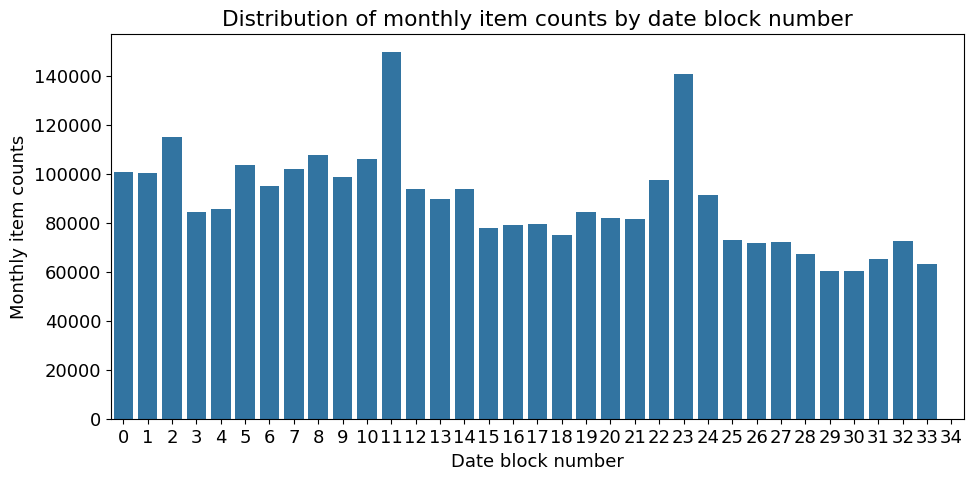

In [30]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
group_month_sum = all_data.groupby('date_block_num',as_index=False).agg({'item_cnt_month': 'sum'})
# group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

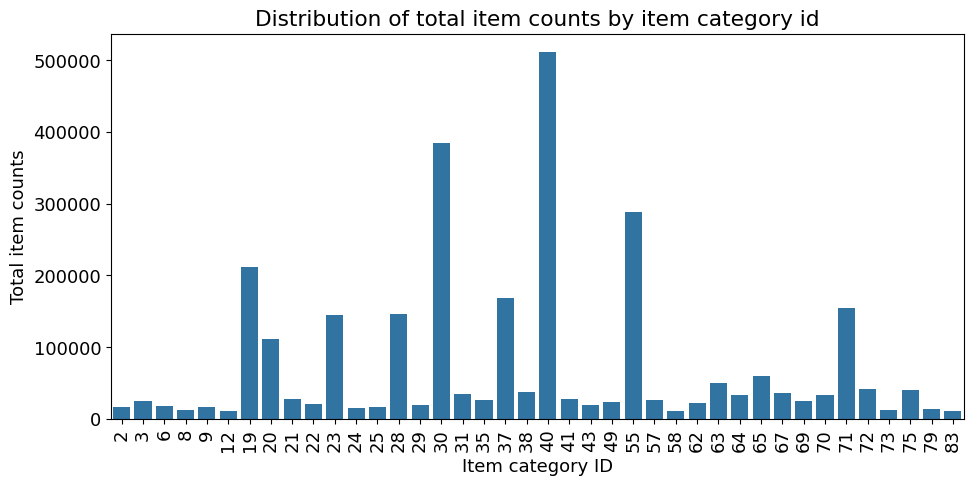

In [31]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
group_cat_sum = all_data.groupby('item_category_id').agg({'item_cnt_month': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_month'] > 10000]

sns.barplot(x='item_category_id', y='item_cnt_month', data=group_cat_sum)
ax.set(title='Distribution of total item counts by item category id',
       xlabel='Item category ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

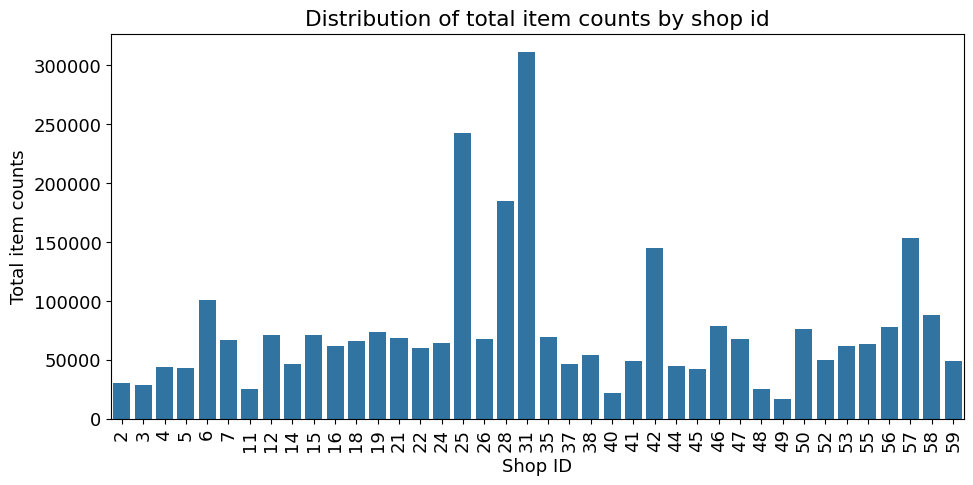

In [32]:
figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by shop_id
group_shop_sum = all_data.groupby('shop_id').agg({'item_cnt_month': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_month'] > 10000]

sns.barplot(x='shop_id', y='item_cnt_month', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

In [33]:
def add_mean_features(df, mean_features, idx_features):
    # Check base features
    assert (idx_features[0] == 'date_block_num') and \
           len(idx_features) in [2, 3]
    #The first element in idx_features is 'date_block_num'.
    #The length of idx_features is either 2 or 3.
    #If these conditions are not met, an AssertionError will be raised.
    
    # Set derived feature name 
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '_mean_sales'
    else:
        feature_name = idx_features[1] + '_' + idx_features[2] + '_mean_sales'
    
    # Get average monthly sales by grouping based on base features
    group = df.groupby(idx_features).agg({'item_cnt_month': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'item_cnt_month': feature_name})
    
    # Merge df with group based on idx_features
    df = df.merge(group, on=idx_features, how='left')
    # Date downcasting
    df = downcast(df, False)
    # Append newly created mean_feature_name features to the mean_features list
    mean_features.append(feature_name)
    
    # Garbage collection
    del group
    gc.collect()
    
    return df, mean_features

In [34]:
# List of derived features containing 'item_id' in the grouping base features
item_mean_features = []


# Create monthly average sales derived features grouped by ['date_block_num', 'item_id']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id'])

# Create monthly average sales derived features grouped by ['date_block_num', 'item_id', 'city']
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['date_block_num', 'item_id', 'city'])

### Feature Engineering II - Create Lag features
Create Average Monthly Sales Derived Feature by Base Feature

In [35]:
item_mean_features

['item_id_mean_sales', 'item_id_city_mean_sales']

In [36]:
# List of derived features containing 'shop_id' in the grouping base features
shop_mean_features = []

# Create monthly average sales derived features grouped by ['date_block_num', 'shop_id', 'item_category_id']
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['date_block_num', 'shop_id', 'item_category_id'])

In [37]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

Create Lag Features

In [38]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # Copy only the part of the DataFrame needed to create the lag features
    df_temp = df[idx_features + [lag_feature]].copy() 

    # Create lag features
    for i in range(1, nlags+1):
        # Lag featrue name
        lag_feature_name = lag_feature +'_lag' + str(i)
        # Set df_temp column name
        df_temp.columns = idx_features + [lag_feature_name]
        # Add 1 to date_block_num feature in df_temp
        df_temp['date_block_num'] += 1
        # Merge df with df_temp based on idx_feature
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # Replace NaN with 0
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # Add lag features to lag_features_to_clip to clip between 0 and 20
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    # Date downcasting
    df = downcast(df, False)
    # Garbage collection
    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

In [39]:
lag_features_to_clip = [] # list of lag features to be clipped to between 0 to 20 
idx_features = ['date_block_num', 'shop_id', 'item_id'] # base features

# Create 3 month lag features of item_cnt_month based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_cnt_month', 
                                                  nlags=3,
                                                  clip=True)

In [40]:
all_data.head().T

,0,1,2,3,4
date_block_num,0.000000,0.000000,0.000000,0.000000,0.000000
shop_id,59.000000,59.000000,59.000000,59.000000,59.000000
item_id,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
item_cnt_month,1.000000,0.000000,0.000000,0.000000,0.000000
item_price_mean,999.000000,0.000000,0.000000,0.000000,0.000000
item_count,1.000000,0.000000,0.000000,0.000000,0.000000
city,30.000000,30.000000,30.000000,30.000000,30.000000
item_category_id,37.000000,58.000000,58.000000,56.000000,59.000000
first_sale_date,0.000000,0.000000,0.000000,0.000000,0.000000
category,5.000000,7.000000,7.000000,7.000000,7.000000


In [41]:
lag_features_to_clip

['item_cnt_month_lag1', 'item_cnt_month_lag2', 'item_cnt_month_lag3']

In [42]:
# Create 3 month lag features of item_count feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_count', 
                                                  nlags=3)

# Create 3 month lag features of item_price_mean feature based on idx_features
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='item_price_mean', 
                                                  nlags=3)

In [43]:
X_test_temp = all_data[all_data['date_block_num'] == 34]
X_test_temp[item_mean_features].sum()

item_id_mean_sales         0.0
item_id_city_mean_sales    0.0
dtype: float32

In [44]:
# Create lag features by item_mean_features element based on dx_features
display(item_mean_features)

for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3)
# Remove features in item_mean_features
all_data = all_data.drop(item_mean_features, axis=1)

['item_id_mean_sales', 'item_id_city_mean_sales']

In [45]:
shop_mean_features

['shop_id_item_category_id_mean_sales']

In [46]:
# Create lag features by shop_mean_features element based on ['date_block_num', 'shop_id', 'item_category_id']
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['date_block_num', 'shop_id', 'item_category_id'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3)
# Remove features in shop_mean_features
all_data = all_data.drop(shop_mean_features, axis=1)

In [47]:
# Remove data less than date ID 3
all_data = all_data.drop(all_data[all_data['date_block_num'] < 3].index)

Other Features Engineering

In [48]:
all_data['item_cnt_month_lag_mean'] = all_data[['item_cnt_month_lag1',
                                         'item_cnt_month_lag2', 
                                         'item_cnt_month_lag3']].mean(axis=1)

In [49]:
# Clip 0~20
all_data[lag_features_to_clip + ['item_cnt_month', 'item_cnt_month_lag_mean']] = all_data[lag_features_to_clip +['item_cnt_month', 'item_cnt_month_lag_mean']].clip(0, 20)

In [50]:
all_data['lag_grad1'] = all_data['item_cnt_month_lag1']/all_data['item_cnt_month_lag2']
all_data['lag_grad1'] = all_data['lag_grad1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['lag_grad2'] = all_data['item_cnt_month_lag2']/all_data['item_cnt_month_lag3']
all_data['lag_grad2'] = all_data['lag_grad2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [51]:
all_data['brand_new'] = all_data['first_sale_date'] == all_data['date_block_num']

In [52]:
all_data['duration_after_first_sale'] = all_data['date_block_num'] - all_data['first_sale_date']
all_data = all_data.drop('first_sale_date', axis=1)

In [53]:
all_data['month'] = all_data['date_block_num']%12

In [54]:
# Remove item_price_mean, item_count features
all_data = all_data.drop(['item_price_mean', 'item_count'], axis=1)
all_data = downcast(all_data, False) # Data downcasting
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8029765 entries, 827196 to 8856960
Data columns (total 31 columns):
 #   Column                                    Dtype  
---  ------                                    -----  
 0   date_block_num                            int8   
 1   shop_id                                   int8   
 2   item_id                                   int16  
 3   item_cnt_month                            int8   
 4   city                                      int8   
 5   item_category_id                          int8   
 6   category                                  int8   
 7   item_cnt_month_lag1                       int8   
 8   item_cnt_month_lag2                       int8   
 9   item_cnt_month_lag3                       int8   
 10  item_count_lag1                           int8   
 11  item_count_lag2                           int8   
 12  item_count_lag3                           int8   
 13  item_price_mean_lag1                      float32
 1

In [55]:
# Train data (Features)
X_train = all_data[all_data['date_block_num'] < 33]
X_train = X_train.drop(['item_cnt_month'], axis=1)
# Valid data (Features)
X_valid = all_data[all_data['date_block_num'] == 33]
X_valid = X_valid.drop(['item_cnt_month'], axis=1)
# Test data (Features)
X_test = all_data[all_data['date_block_num'] == 34]
X_test = X_test.drop(['item_cnt_month'], axis=1)

# Train data (Target values)
y_train = all_data[all_data['date_block_num'] < 33]['item_cnt_month']
# Valid data (Target values)
y_valid = all_data[all_data['date_block_num'] == 33]['item_cnt_month']

# Garbage collection
del all_data
gc.collect();

### Train model and Submit

#### Model01: LightGBM

In [56]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',
          'num_leaves': 256,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

cat_features = ['shop_id', 'city', 'item_category_id', 'category', 'month']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# Define callbacks
early_stopping_callback = lgb.early_stopping(stopping_rounds=500)
log_evaluation_callback = lgb.log_evaluation(period=100)  # Logs every 100 iterations

# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=2400,
                      valid_sets=(dtrain, dvalid),
                      categorical_feature=cat_features,
                      callbacks=[early_stopping_callback, log_evaluation_callback]) 

[LightGBM] [Info] Total Bins 3971
[LightGBM] [Info] Number of data points in the train set: 7593847, number of used features: 30
[LightGBM] [Info] Start training from score 0.307756
Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 1.0177	valid_1's rmse: 0.913731
[200]	training's rmse: 0.912432	valid_1's rmse: 0.841858
[300]	training's rmse: 0.859367	valid_1's rmse: 0.811976
[400]	training's rmse: 0.83033	valid_1's rmse: 0.800156
[500]	training's rmse: 0.810862	valid_1's rmse: 0.79614
[600]	training's rmse: 0.797279	valid_1's rmse: 0.794811
[700]	training's rmse: 0.786932	valid_1's rmse: 0.794764
[800]	training's rmse: 0.778527	valid_1's rmse: 0.794732
[900]	training's rmse: 0.771477	valid_1's rmse: 0.794794
[1000]	training's rmse: 0.76539	valid_1's rmse: 0.794724
Early stopping, best iteration is:
[585]	training's rmse: 0.799125	valid_1's rmse: 0.794661


In [57]:
preds = lgb_model.predict(X_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission_lgb1.csv', index=False)

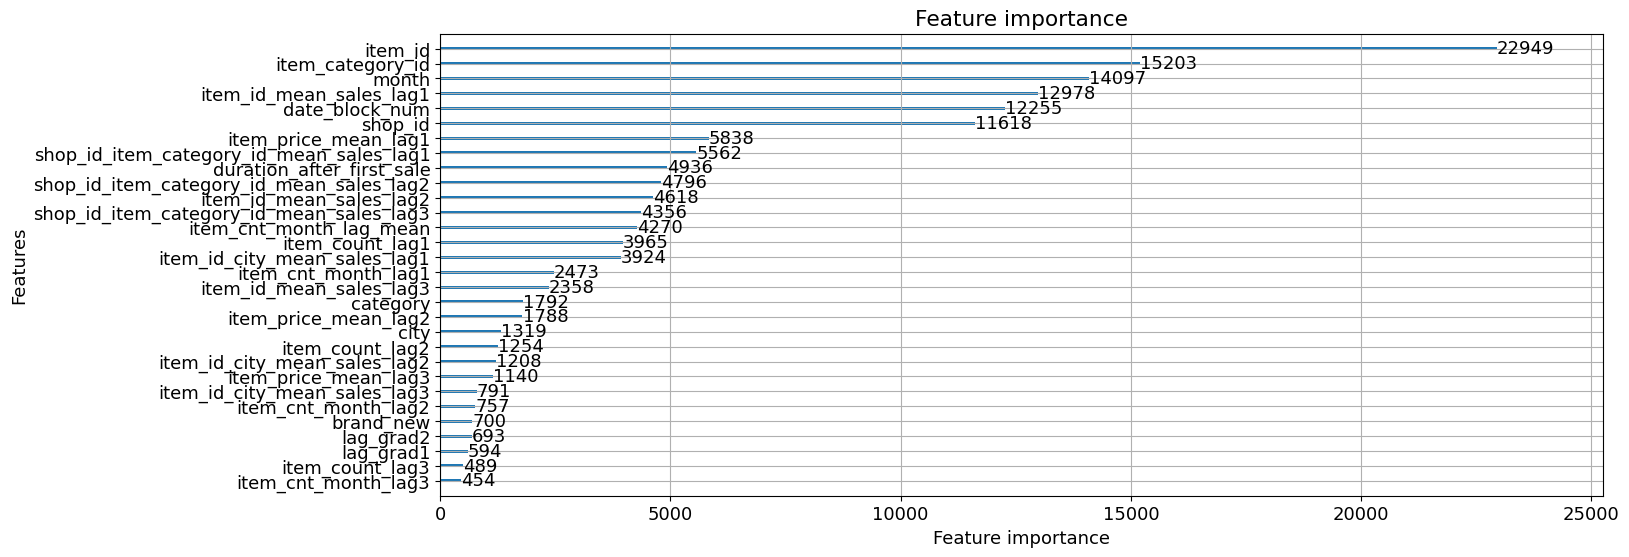

In [58]:
plt.rcParams["figure.figsize"] = (15, 6)
lgb.plot_importance(lgb_model, importance_type='split')
plt.show()

#### Model02: CatBoost

In [59]:
import catboost
from catboost import Pool
from catboost import CatBoostRegressor

In [60]:
# List of column names I am gonna getting the indices for
cat_features = ['shop_id', 'city', 'item_category_id', 'category', 'month']

# Get the column indices
cat_features_indices = [X_train.columns.get_loc(col) for col in cat_features]

print(cat_features_indices)

[1, 3, 4, 5, 29]


In [61]:
cat_features = cat_features_indices

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid)
)

Learning rate set to 0.316051
0:	learn: 1.1164673	test: 0.9892355	best: 0.9892355 (0)	total: 999ms	remaining: 8m 18s
50:	learn: 0.8802572	test: 0.8119471	best: 0.8116597 (47)	total: 39.3s	remaining: 5m 46s
100:	learn: 0.8653092	test: 0.8051223	best: 0.8051223 (100)	total: 1m 20s	remaining: 5m 16s
150:	learn: 0.8572170	test: 0.8045357	best: 0.8037910 (127)	total: 1m 59s	remaining: 4m 36s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 0.8037909724
bestIteration = 127

Shrink model to first 128 iterations.


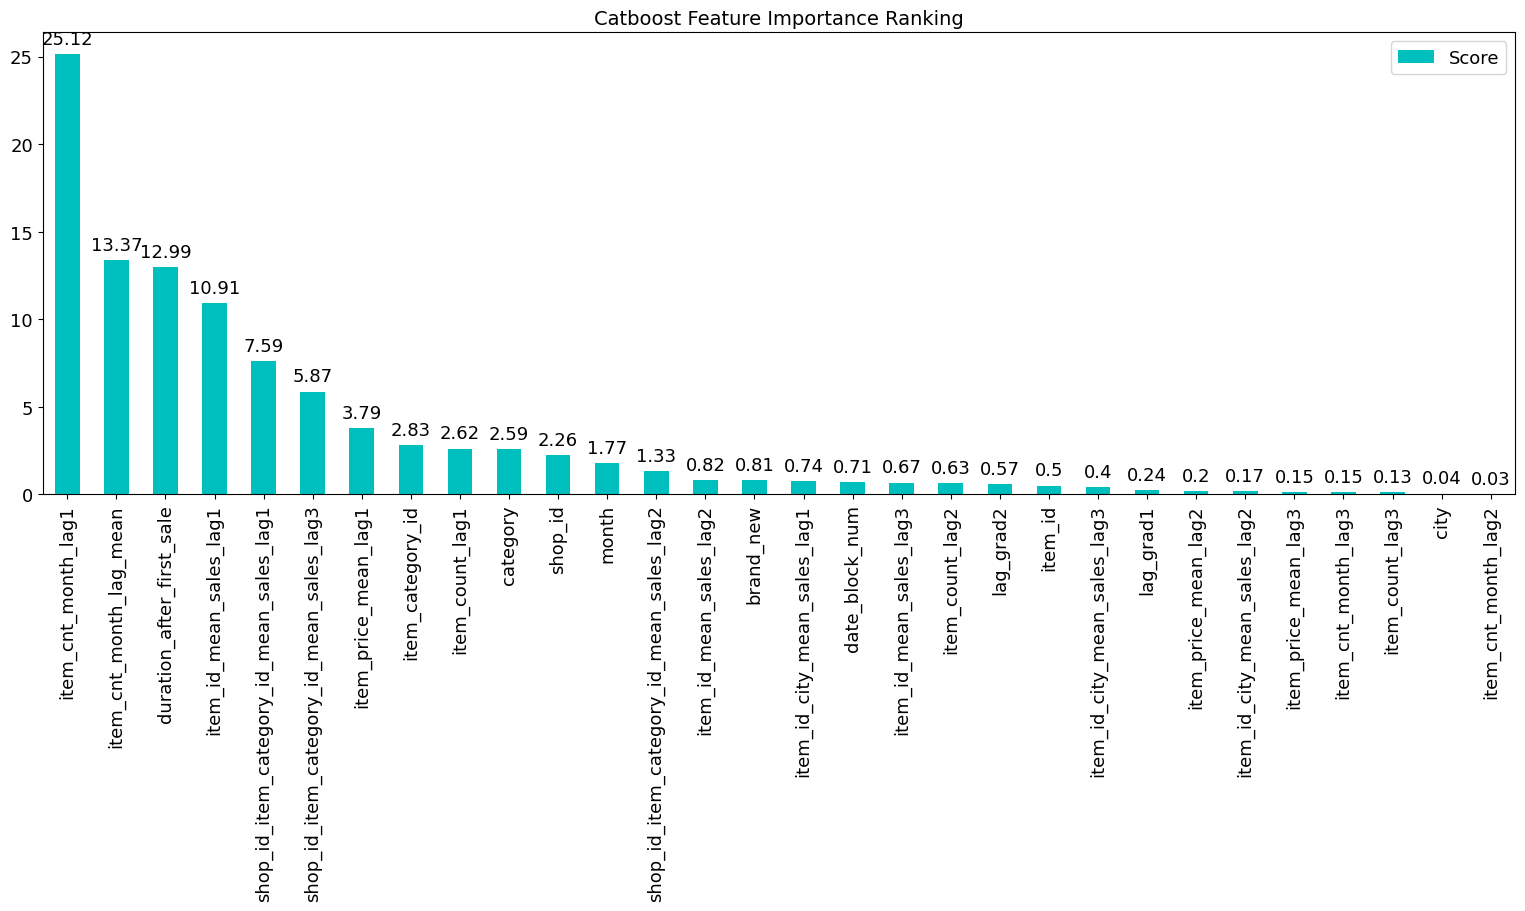

In [62]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, catboost_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_features)))), columns=['Feature','Score'])
feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (19, 6)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')
rects = ax.patches
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [63]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_valid)
catboost_test_pred = catboost_model.predict(X_test).clip(0, 20)

In [64]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, catboost_val_pred)))

Train rmse: 0.8599941871129043
Validation rmse: 0.8037909724310585


In [65]:
preds = catboost_model.predict(X_test).clip(0, 20)

submission['item_cnt_month'] = preds
submission.to_csv('submission_catboost.csv', index=False)

#### Model03: XGBoost

In [66]:
# # Use only part of features on XGBoost.
# xgb_features = ['date_block_num','shop_id', 'item_id', 'city', 'category','item_cnt_month_lag1','item_cnt_month_lag2','item_cnt_month_lag3',
# 'item_price_mean_lag1', 'item_price_mean_lag2','item_price_mean_lag3','item_id_mean_sales_lag1','item_id_mean_sales_lag2',
# 'item_id_mean_sales_lag3','item_id_city_mean_sales_lag1', 'item_id_city_mean_sales_lag2','item_id_city_mean_sales_lag3',
# 'shop_id_item_category_id_mean_sales_lag1','shop_id_item_category_id_mean_sales_lag2','shop_id_item_category_id_mean_sales_lag3', 
# 'duration_after_first_sale','month']

xgb_features = X_train.columns
xgb_train = X_train[xgb_features]
xgb_val = X_valid[xgb_features]
xgb_test = X_test[xgb_features]

In [67]:
from xgboost import XGBRegressor
from xgboost import plot_importance

In [68]:
xgb_model = XGBRegressor(max_depth=8,              #Sets the maximum depth of each tree in the model. A deeper tree can capture more complex patterns but may overfit the data.
                         n_estimators=500,         #Specifies the number of boosting rounds or trees to be built. More trees generally lead to better performance, but too many can cause overfitting.
                         min_child_weight=1000,    #Controls the minimum sum of instance weights (hessian) needed in a child. Larger values prevent the model from learning overly specific patterns in the data, which can reduce overfitting.
                         colsample_bytree=0.7,     #Specifies the fraction of features (columns) to sample when building each tree. Setting it to 0.7 means that 70% of the features are randomly sampled for each tree, which helps prevent overfitting.
                         subsample=0.7,            #Defines the fraction of the training data that is randomly sampled for each boosting round. Using 70% of the data helps to prevent overfitting by introducing randomness.
                         eta=0.3,                  #This is the learning rate, also known as eta in XGBoost. It controls how much the model's weights are adjusted with respect to the gradient direction in each round. A lower value slows down learning but can lead to a more accurate model, whereas a higher value speeds up learning but might lead to overshooting the optimal solution.
                         eval_metric="rmse", 
                         early_stopping_rounds=50,
                         seed=0)
xgb_model.fit(xgb_train, 
              y_train, 
              eval_set=[(xgb_train, y_train), (xgb_val, y_valid)], 
              verbose=20,     #Controls how often the training progress is printed. Setting it to 20 means that the training progress will be reported every 20 boosting rounds.
              )   #Enables early stopping, a technique to prevent overfitting. If the validation score does not improve for 20 consecutive rounds, training will stop early, and the model will revert to the state with the best validation score.

[0]	validation_0-rmse:1.08548	validation_1-rmse:0.96259
[20]	validation_0-rmse:0.86372	validation_1-rmse:0.80644
[40]	validation_0-rmse:0.85249	validation_1-rmse:0.80401
[60]	validation_0-rmse:0.84646	validation_1-rmse:0.80261
[80]	validation_0-rmse:0.84133	validation_1-rmse:0.80137
[100]	validation_0-rmse:0.83579	validation_1-rmse:0.79968
[120]	validation_0-rmse:0.83390	validation_1-rmse:0.80016
[140]	validation_0-rmse:0.83123	validation_1-rmse:0.79907
[160]	validation_0-rmse:0.82917	validation_1-rmse:0.80005
[180]	validation_0-rmse:0.82766	validation_1-rmse:0.79992
[200]	validation_0-rmse:0.82548	validation_1-rmse:0.79785
[220]	validation_0-rmse:0.82385	validation_1-rmse:0.79796
[240]	validation_0-rmse:0.82162	validation_1-rmse:0.79913
[242]	validation_0-rmse:0.82149	validation_1-rmse:0.79917


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=50,
             enable_categorical=False, eta=0.3, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=1000, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

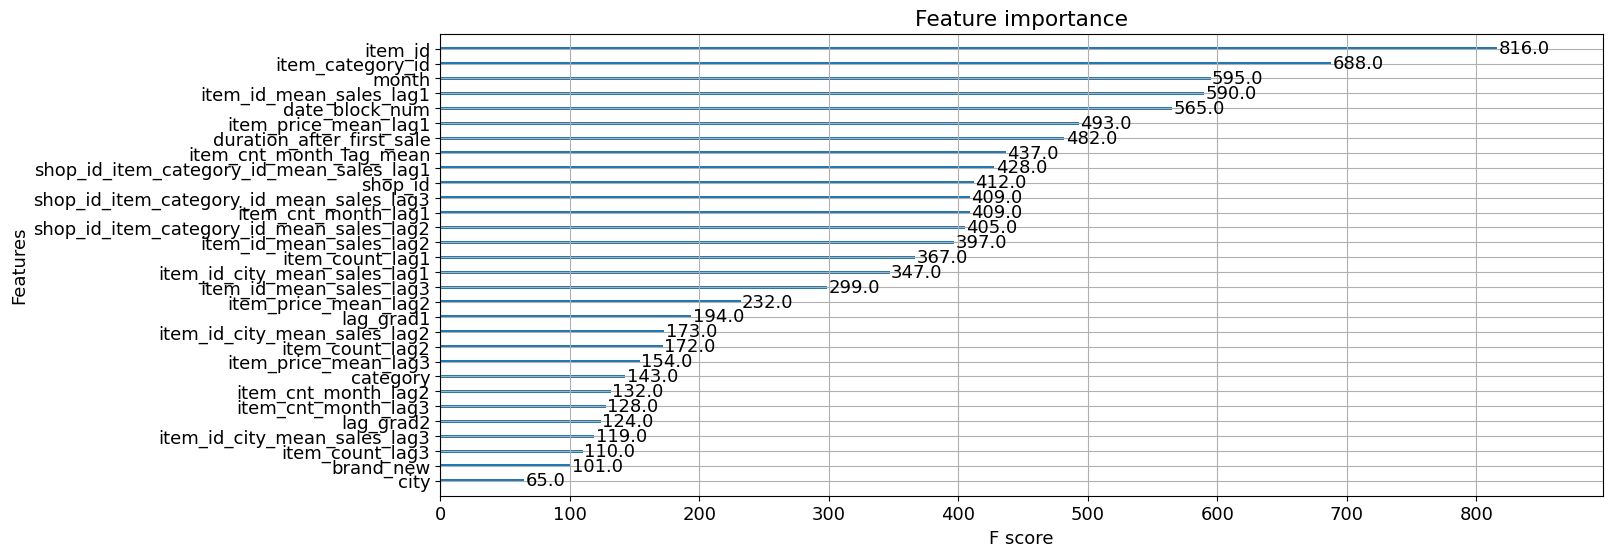

In [69]:
plt.rcParams["figure.figsize"] = (15, 6)
plot_importance(xgb_model)
plt.show()

In [70]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [71]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, xgb_val_pred)))

Train rmse: 0.8261454
Validation rmse: 0.796617


In [72]:
preds = xgb_test_pred.clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission_xgb.csv', index=False)

#### Model04: Random Forest

In [73]:
# Use only part of features on random forest.
df_features = ['date_block_num','shop_id', 'item_id', 'city', 'category','item_cnt_month_lag1','item_cnt_month_lag2','item_cnt_month_lag3',
'item_price_mean_lag1', 'item_price_mean_lag2','item_price_mean_lag3','item_id_mean_sales_lag1','item_id_mean_sales_lag2',
'item_id_mean_sales_lag3','item_id_city_mean_sales_lag1', 'item_id_city_mean_sales_lag2','item_id_city_mean_sales_lag3',
'shop_id_item_category_id_mean_sales_lag1','shop_id_item_category_id_mean_sales_lag2','shop_id_item_category_id_mean_sales_lag3', 
'duration_after_first_sale','month']

rf_features = X_train.columns
rf_train = X_train[rf_features]
rf_val = X_valid[rf_features]
rf_test = X_test[rf_features]

In [74]:
from sklearn.ensemble import RandomForestRegressor

In [75]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf_model.fit(rf_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, n_jobs=-1, random_state=0)

In [76]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [77]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, rf_val_pred)))

Train rmse: 0.9058467349306842
Validation rmse: 0.8362497079489273


In [78]:
preds = rf_model.predict(rf_test).clip(0,20)
submission['item_cnt_month'] = preds
submission.to_csv('submission_RF.csv', index=False)